# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

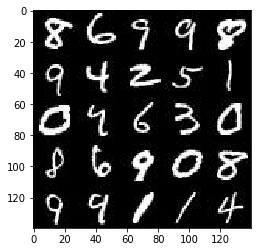

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

data_dir = './data' 
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

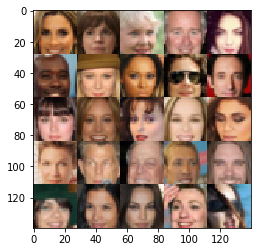

In [3]:
# show_n_images = 25

# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.10.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'lr')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

**AA**: I used convolutional networks in this assignment, since, to the best of my understanding, they are expected to work well with image data. As in the DCGAN paper, I didn't include any pooling layers. I also included batch normalization and the leaky RELU activation function, as learnt in class.

Here I Use batch normalization starting from the second convolutional layer (i.e., excluding the first and output layers). Using strides of 2, data's shape becomes increasingly deep (i.e., has more filters) as it goes through the network's layers. Output is a a single real number (using a sigmoid function) representing the probability of the input to be a fake (i.e., created by the generator network) or real image (i.e., taken from the MNIST/CelebA data set).  
I also used dropout to reduce overfitting and increase generalization.

I also added the following inputs: an alpha function value for leaky relu (defaulting to 0.2), a boolean reuse value (defaulting to False, and a dropout probablity (defaulting to 0.2).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, dropout_rate=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # For disciminator, always use traninig=True.
    is_train = True
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Create sequential convolutional layers.
        
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # Better results were obtained when not using batch normaliztion for the first conv layer
        # x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(inputs=x, rate=dropout_rate, training=is_train) # Apply dorpout
        x = tf.maximum(alpha * x, x)   # Apply leaky relu activation fucntion
        
         
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(inputs=x, rate=dropout_rate, training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(inputs=x, rate=dropout_rate, training=is_train)
        x = tf.maximum(alpha * x, x)

        # Flatten last convolutional layer's output
        flat = tf.reshape(x, (-1, 4*4*256))

        # Add a fully connected layer and calculate output logits and sigmoids
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.nn.sigmoid(logits)

        return output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

**AA:** For the generator, the first is a fully connected layer, receiving random z vectors as input. Following, sequential transposed convolutional layers are applied, increasingly reducing depth and increasing width and height. 
Output is a generated image, having the same shape as the real images. A tanh activation function is used for the output, known to work best for these type of generators.

All layers include batch normalization and a leaky relu activation function. 
I also used dropout to reduce overfitting and increase generalization.

I again added the following inputs: an alpha function value for leaky relu (defaulting to 0.2), a boolean reuse input (defaulting to False) and dropout probability (defaulting to 0.2).

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, dropout_rate=0.2):
    # AA: I added alpha input for leaky relu.
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    reuse = not is_train

    with tf.variable_scope('generator', reuse=reuse):
        
        # First layer is fully connected
        x = tf.layers.dense(z, 7*7*512, activation=None)
        x = tf.reshape(x, (-1,7,7,512)) # Reshape first layer as small and deep
        
        # Create sequential convolutional layers
        
        x = tf.layers.batch_normalization(x, training=is_train) # Apply batch normalization
        x = tf.layers.dropout(inputs=x, rate=dropout_rate, training=is_train) # Apply dropout (if training)
        x = tf.maximum(alpha * x, x) # Apply leaky relu activation function
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding ='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(inputs=x, rate=dropout_rate, training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding ='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(inputs=x, rate=dropout_rate, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding ='same')
                
        # Return generated images (using tanh activation function) 
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

AA: 
Define "opposing" loss functions (sigmoid cross-entropy) for discriminator and generator models for generated fake images (i.e., labels of zeros and ones, respectievly). Similarly use (smoothed) labels of ones for the deiscriminator loss function for real images. Total cost for the discriminator equals the sum of cost for real and fake images.    
I added the following inputs: an alpha function value for leaky relu (defaulting to 0.2), a smoothing factor (defaulting to 0.1) and dropout probabilities for both discriminator and generator (defaulting to 0.2).

In [8]:
def model_loss(input_real,
               input_z,
               out_channel_dim,
               alpha=0.2,
               smooth=0.1,
               disc_dropOut=0.5,
               gen_dropOut=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Get outputs and logits
    g_model_fake = generator(
        input_z,
        out_channel_dim,
        is_train=True,
        alpha=alpha,
        dropout_rate=gen_dropOut)
    d_model_real, d_logits_real = discriminator(
        input_real, reuse=False, alpha=alpha, dropout_rate=disc_dropOut)
    d_model_fake, d_logits_fake = discriminator(
        g_model_fake, reuse=True, alpha=alpha, dropout_rate=disc_dropOut)

    # Define loss functions
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=(tf.ones_like(d_model_real) * (1 - smooth))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    # for discrimintor: Total cost equals the sum of cost for real and fake images
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

AA: use adam optimizer to minimize loss function of seperetaly for the discriminator and generator models.

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get trainable variables for the discriminator and generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Set optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

AA: 
Use previously defined functions to train both discriminator and generator models by creating placeholders, building networks, defining loss functions and optimizing each model. 
Also, present models' losses and generated images (by the generator) during training.
Here I train the generator twice to improve its performance relative to the discriminator.
I added inputs for alpha, smoothing factor, and dropout probability for discriminator and generator, to be passed on to the relevant functions.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          alpha=0.2, smooth=0.1, disc_dropOut=0.2, gen_dropOut=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Create input placeholders
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Build networks for training and loss calculation
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1], alpha=alpha, smooth=smooth,  
                                disc_dropOut= disc_dropOut)
    
    # Create optimizing operations
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step_count = 0 # Initiate a step counter
    
    # Set number of steps before displaying losses and generator output
    steps_disp_loss = 50
    steps_disp_output = 100
    
    n_images_disp = 9 # Set number of generated images to display each time
    
    start_time = time.time() # Keep track of time
    
    # Train the discriminator and generator models
    with tf.Session() as sess:
        
        
        # Initialize weights using Xavier with normal distribution
        tf.get_variable_scope().set_initializer(tf.glorot_uniform_initializer)
                                                
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step_count += 1
                
                # Generate random noise Z vectors
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # Transform value limits from [-0.5,0.5] to [-1,1]
                batch_images = batch_images*2
                
                # Run optimizers. 
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                # Train generator twice to improve its perforamnces relative to the discriminator
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})
        
                # Display losses
                if step_count % steps_disp_loss == 0:
                    inter_d_loss = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    inter_g_loss = g_loss.eval({inputs_z: batch_z})
                    
                    print('\n Epoch {}/{}, step {}: \n Discriminator loss: {:.4f} \n Generator loss: {:.4f} \n Total Time: {:.2f} minutes'\
                          .format(epoch+1,epoch_count, step_count, inter_d_loss, inter_g_loss,
                                  (time.time()-start_time)/60))
                
                # Display generator outputs
                if step_count % steps_disp_output == 0:
                    show_generator_output(sess, n_images_disp, inputs_z, data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


 Epoch 1/2, step 50: 
 Discriminator loss: 1.8481 
 Generator loss: 0.7903 
 Total Time: 0.37 minutes

 Epoch 1/2, step 100: 
 Discriminator loss: 1.5842 
 Generator loss: 0.6996 
 Total Time: 0.68 minutes


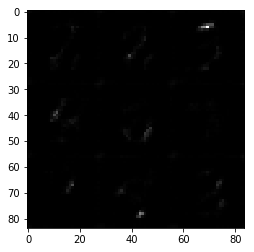


 Epoch 1/2, step 150: 
 Discriminator loss: 1.7084 
 Generator loss: 1.1238 
 Total Time: 1.01 minutes

 Epoch 1/2, step 200: 
 Discriminator loss: 1.4368 
 Generator loss: 0.5796 
 Total Time: 1.31 minutes


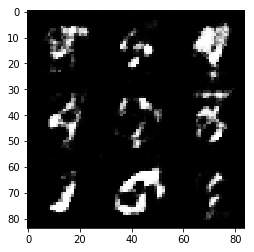


 Epoch 1/2, step 250: 
 Discriminator loss: 1.5091 
 Generator loss: 1.0055 
 Total Time: 1.62 minutes

 Epoch 1/2, step 300: 
 Discriminator loss: 1.4679 
 Generator loss: 0.6218 
 Total Time: 1.93 minutes


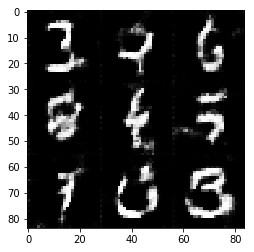


 Epoch 1/2, step 350: 
 Discriminator loss: 1.4142 
 Generator loss: 0.8896 
 Total Time: 2.25 minutes

 Epoch 1/2, step 400: 
 Discriminator loss: 1.5379 
 Generator loss: 0.6936 
 Total Time: 2.56 minutes


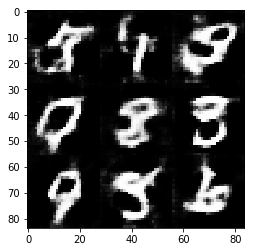


 Epoch 1/2, step 450: 
 Discriminator loss: 1.5224 
 Generator loss: 0.8326 
 Total Time: 2.87 minutes

 Epoch 1/2, step 500: 
 Discriminator loss: 1.4093 
 Generator loss: 0.9322 
 Total Time: 3.18 minutes


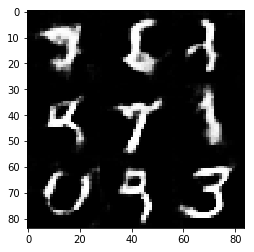


 Epoch 1/2, step 550: 
 Discriminator loss: 1.4025 
 Generator loss: 0.9985 
 Total Time: 3.49 minutes

 Epoch 1/2, step 600: 
 Discriminator loss: 1.5400 
 Generator loss: 0.7068 
 Total Time: 3.80 minutes


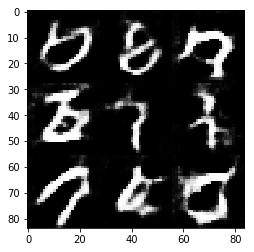


 Epoch 1/2, step 650: 
 Discriminator loss: 1.4349 
 Generator loss: 0.7917 
 Total Time: 4.12 minutes

 Epoch 1/2, step 700: 
 Discriminator loss: 1.2790 
 Generator loss: 1.0318 
 Total Time: 4.43 minutes


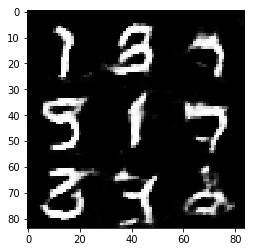


 Epoch 1/2, step 750: 
 Discriminator loss: 1.2819 
 Generator loss: 1.1040 
 Total Time: 4.74 minutes

 Epoch 1/2, step 800: 
 Discriminator loss: 1.4045 
 Generator loss: 0.7531 
 Total Time: 5.05 minutes


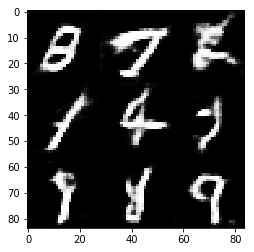


 Epoch 1/2, step 850: 
 Discriminator loss: 1.3965 
 Generator loss: 1.1115 
 Total Time: 5.37 minutes

 Epoch 1/2, step 900: 
 Discriminator loss: 1.3862 
 Generator loss: 0.6565 
 Total Time: 5.68 minutes


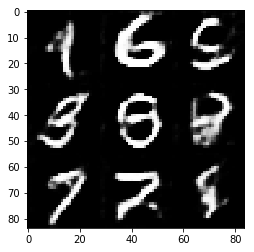


 Epoch 2/2, step 950: 
 Discriminator loss: 1.5038 
 Generator loss: 0.6836 
 Total Time: 5.99 minutes

 Epoch 2/2, step 1000: 
 Discriminator loss: 1.3250 
 Generator loss: 0.9940 
 Total Time: 6.29 minutes


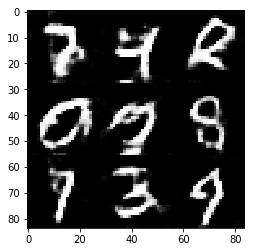


 Epoch 2/2, step 1050: 
 Discriminator loss: 1.3598 
 Generator loss: 0.6926 
 Total Time: 6.59 minutes

 Epoch 2/2, step 1100: 
 Discriminator loss: 1.2973 
 Generator loss: 0.9015 
 Total Time: 6.90 minutes


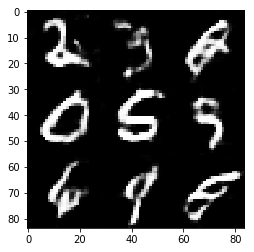


 Epoch 2/2, step 1150: 
 Discriminator loss: 1.3716 
 Generator loss: 0.8100 
 Total Time: 7.21 minutes

 Epoch 2/2, step 1200: 
 Discriminator loss: 1.3464 
 Generator loss: 0.8757 
 Total Time: 7.51 minutes


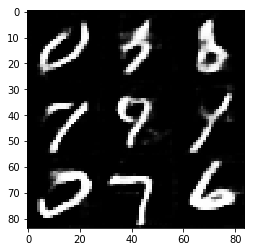


 Epoch 2/2, step 1250: 
 Discriminator loss: 1.2325 
 Generator loss: 1.0380 
 Total Time: 7.82 minutes

 Epoch 2/2, step 1300: 
 Discriminator loss: 1.2877 
 Generator loss: 0.9648 
 Total Time: 8.12 minutes


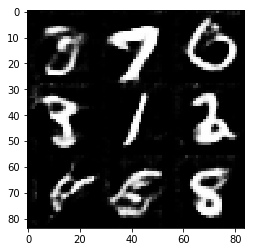


 Epoch 2/2, step 1350: 
 Discriminator loss: 1.3356 
 Generator loss: 0.9763 
 Total Time: 8.43 minutes

 Epoch 2/2, step 1400: 
 Discriminator loss: 1.3808 
 Generator loss: 0.6987 
 Total Time: 8.74 minutes


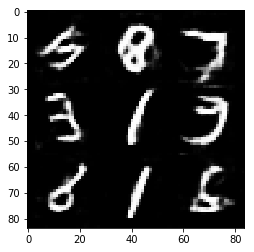


 Epoch 2/2, step 1450: 
 Discriminator loss: 1.3948 
 Generator loss: 0.7667 
 Total Time: 9.05 minutes

 Epoch 2/2, step 1500: 
 Discriminator loss: 1.4468 
 Generator loss: 0.7880 
 Total Time: 9.35 minutes


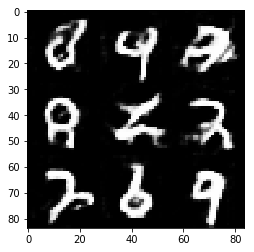


 Epoch 2/2, step 1550: 
 Discriminator loss: 1.3116 
 Generator loss: 0.7688 
 Total Time: 9.66 minutes

 Epoch 2/2, step 1600: 
 Discriminator loss: 1.3080 
 Generator loss: 0.9085 
 Total Time: 9.96 minutes


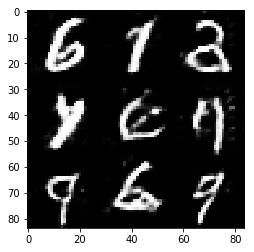


 Epoch 2/2, step 1650: 
 Discriminator loss: 1.3632 
 Generator loss: 0.8228 
 Total Time: 10.26 minutes

 Epoch 2/2, step 1700: 
 Discriminator loss: 1.2251 
 Generator loss: 0.8736 
 Total Time: 10.57 minutes


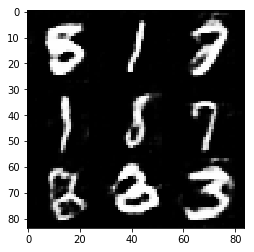


 Epoch 2/2, step 1750: 
 Discriminator loss: 1.4852 
 Generator loss: 1.0351 
 Total Time: 10.88 minutes

 Epoch 2/2, step 1800: 
 Discriminator loss: 1.2905 
 Generator loss: 0.8824 
 Total Time: 11.18 minutes


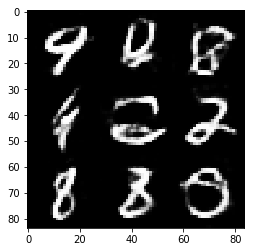


 Epoch 2/2, step 1850: 
 Discriminator loss: 1.4018 
 Generator loss: 1.0532 
 Total Time: 11.50 minutes


In [12]:
batch_size = 64 # 128
z_dim = 150 # 100
learning_rate = 0.0002 # 0.001 # 0.003 # 0.005
beta1 = 0.5 # 0.3 #0.1
alpha = 0.2 #0.1 # 0.05
smooth = 0.1 # 0.2 #0.05
disc_dropOut = 0.2 #0.4 0.5
gen_dropOut = 0.1 #0.2 #0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode,alpha=alpha, smooth=smooth, 
          disc_dropOut=disc_dropOut, gen_dropOut=gen_dropOut)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.


 Epoch 1/1, step 50: 
 Discriminator loss: 0.8657 
 Generator loss: 1.4926 
 Total Time: 0.37 minutes

 Epoch 1/1, step 100: 
 Discriminator loss: 1.0306 
 Generator loss: 1.8701 
 Total Time: 0.72 minutes


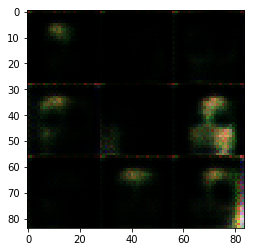


 Epoch 1/1, step 150: 
 Discriminator loss: 1.2315 
 Generator loss: 1.1853 
 Total Time: 1.08 minutes

 Epoch 1/1, step 200: 
 Discriminator loss: 1.1901 
 Generator loss: 2.3260 
 Total Time: 1.43 minutes


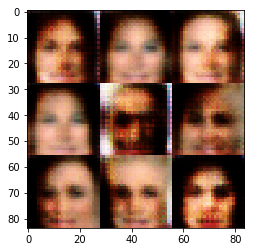


 Epoch 1/1, step 250: 
 Discriminator loss: 1.3934 
 Generator loss: 1.0609 
 Total Time: 1.78 minutes

 Epoch 1/1, step 300: 
 Discriminator loss: 1.4497 
 Generator loss: 0.7213 
 Total Time: 2.12 minutes


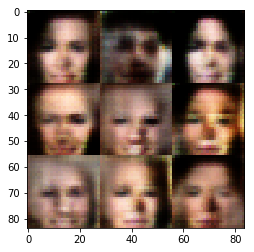


 Epoch 1/1, step 350: 
 Discriminator loss: 1.5156 
 Generator loss: 0.9606 
 Total Time: 2.47 minutes

 Epoch 1/1, step 400: 
 Discriminator loss: 1.5664 
 Generator loss: 0.7509 
 Total Time: 2.82 minutes


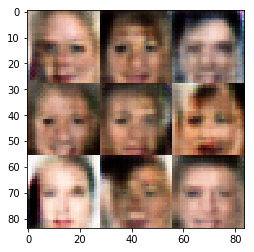


 Epoch 1/1, step 450: 
 Discriminator loss: 1.4205 
 Generator loss: 0.8615 
 Total Time: 3.18 minutes

 Epoch 1/1, step 500: 
 Discriminator loss: 1.6628 
 Generator loss: 0.7545 
 Total Time: 3.54 minutes


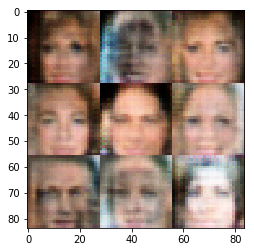


 Epoch 1/1, step 550: 
 Discriminator loss: 1.6509 
 Generator loss: 0.7820 
 Total Time: 3.91 minutes

 Epoch 1/1, step 600: 
 Discriminator loss: 1.5223 
 Generator loss: 0.7717 
 Total Time: 4.26 minutes


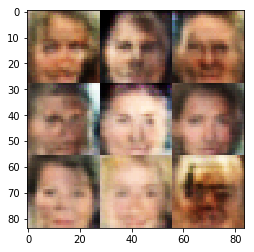


 Epoch 1/1, step 650: 
 Discriminator loss: 1.5700 
 Generator loss: 0.7616 
 Total Time: 4.62 minutes

 Epoch 1/1, step 700: 
 Discriminator loss: 1.4701 
 Generator loss: 0.8443 
 Total Time: 4.99 minutes


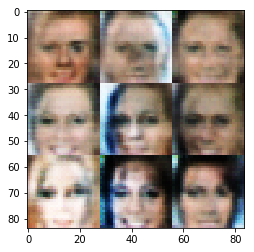


 Epoch 1/1, step 750: 
 Discriminator loss: 1.4397 
 Generator loss: 0.7922 
 Total Time: 5.36 minutes

 Epoch 1/1, step 800: 
 Discriminator loss: 1.4484 
 Generator loss: 0.7439 
 Total Time: 5.70 minutes


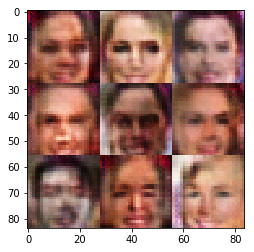


 Epoch 1/1, step 850: 
 Discriminator loss: 1.4881 
 Generator loss: 0.8694 
 Total Time: 6.06 minutes

 Epoch 1/1, step 900: 
 Discriminator loss: 1.5123 
 Generator loss: 0.6233 
 Total Time: 6.41 minutes


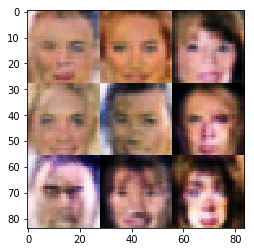


 Epoch 1/1, step 950: 
 Discriminator loss: 1.4453 
 Generator loss: 0.7459 
 Total Time: 6.77 minutes

 Epoch 1/1, step 1000: 
 Discriminator loss: 1.4840 
 Generator loss: 0.8242 
 Total Time: 7.12 minutes


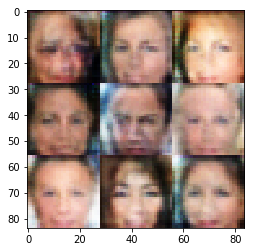


 Epoch 1/1, step 1050: 
 Discriminator loss: 1.5065 
 Generator loss: 0.7581 
 Total Time: 7.47 minutes

 Epoch 1/1, step 1100: 
 Discriminator loss: 1.4415 
 Generator loss: 0.7725 
 Total Time: 7.82 minutes


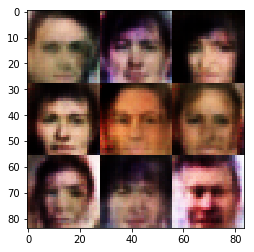


 Epoch 1/1, step 1150: 
 Discriminator loss: 1.5003 
 Generator loss: 0.8518 
 Total Time: 8.17 minutes

 Epoch 1/1, step 1200: 
 Discriminator loss: 1.5033 
 Generator loss: 0.7759 
 Total Time: 8.52 minutes


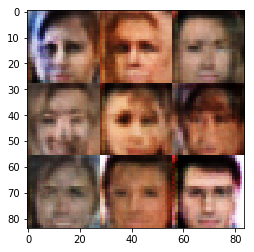


 Epoch 1/1, step 1250: 
 Discriminator loss: 1.4599 
 Generator loss: 0.7602 
 Total Time: 8.87 minutes

 Epoch 1/1, step 1300: 
 Discriminator loss: 1.4717 
 Generator loss: 0.8126 
 Total Time: 9.22 minutes


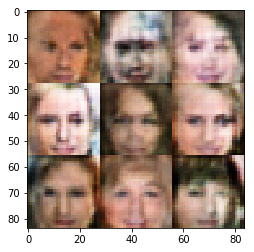


 Epoch 1/1, step 1350: 
 Discriminator loss: 1.4722 
 Generator loss: 0.8201 
 Total Time: 9.59 minutes

 Epoch 1/1, step 1400: 
 Discriminator loss: 1.4581 
 Generator loss: 0.8031 
 Total Time: 9.94 minutes


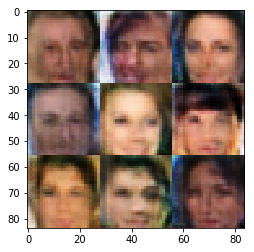


 Epoch 1/1, step 1450: 
 Discriminator loss: 1.4956 
 Generator loss: 0.8412 
 Total Time: 10.31 minutes

 Epoch 1/1, step 1500: 
 Discriminator loss: 1.4177 
 Generator loss: 0.7781 
 Total Time: 10.67 minutes


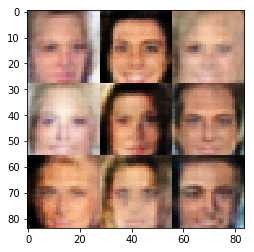


 Epoch 1/1, step 1550: 
 Discriminator loss: 1.4306 
 Generator loss: 0.8007 
 Total Time: 11.05 minutes

 Epoch 1/1, step 1600: 
 Discriminator loss: 1.5254 
 Generator loss: 0.7189 
 Total Time: 11.42 minutes


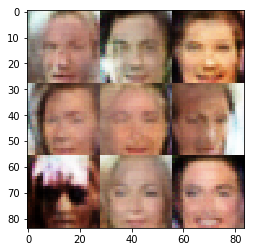


 Epoch 1/1, step 1650: 
 Discriminator loss: 1.4546 
 Generator loss: 0.7747 
 Total Time: 11.80 minutes

 Epoch 1/1, step 1700: 
 Discriminator loss: 1.4069 
 Generator loss: 0.8004 
 Total Time: 12.17 minutes


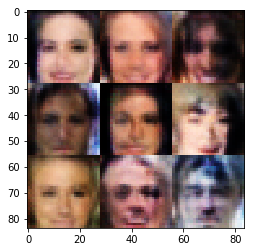


 Epoch 1/1, step 1750: 
 Discriminator loss: 1.4424 
 Generator loss: 0.7588 
 Total Time: 12.55 minutes

 Epoch 1/1, step 1800: 
 Discriminator loss: 1.3995 
 Generator loss: 0.7858 
 Total Time: 12.92 minutes


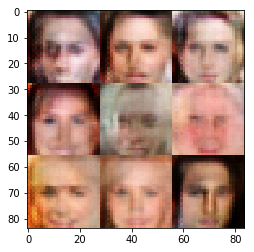


 Epoch 1/1, step 1850: 
 Discriminator loss: 1.4148 
 Generator loss: 0.7759 
 Total Time: 13.29 minutes

 Epoch 1/1, step 1900: 
 Discriminator loss: 1.3952 
 Generator loss: 0.7727 
 Total Time: 13.66 minutes


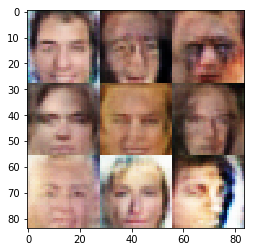


 Epoch 1/1, step 1950: 
 Discriminator loss: 1.4259 
 Generator loss: 0.7129 
 Total Time: 14.04 minutes

 Epoch 1/1, step 2000: 
 Discriminator loss: 1.4327 
 Generator loss: 0.8078 
 Total Time: 14.41 minutes


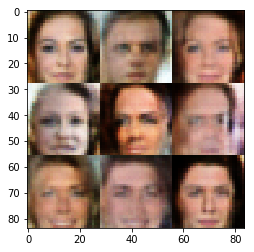


 Epoch 1/1, step 2050: 
 Discriminator loss: 1.4136 
 Generator loss: 0.8188 
 Total Time: 14.78 minutes

 Epoch 1/1, step 2100: 
 Discriminator loss: 1.4711 
 Generator loss: 0.7695 
 Total Time: 15.15 minutes


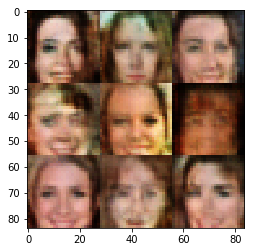


 Epoch 1/1, step 2150: 
 Discriminator loss: 1.3876 
 Generator loss: 0.7604 
 Total Time: 15.52 minutes

 Epoch 1/1, step 2200: 
 Discriminator loss: 1.4308 
 Generator loss: 0.7682 
 Total Time: 15.88 minutes


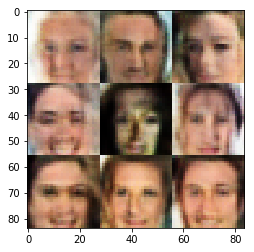


 Epoch 1/1, step 2250: 
 Discriminator loss: 1.4361 
 Generator loss: 0.7293 
 Total Time: 16.24 minutes

 Epoch 1/1, step 2300: 
 Discriminator loss: 1.3808 
 Generator loss: 0.7728 
 Total Time: 16.59 minutes


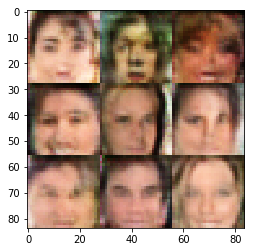


 Epoch 1/1, step 2350: 
 Discriminator loss: 1.3999 
 Generator loss: 0.7812 
 Total Time: 16.97 minutes

 Epoch 1/1, step 2400: 
 Discriminator loss: 1.3919 
 Generator loss: 0.8302 
 Total Time: 17.34 minutes


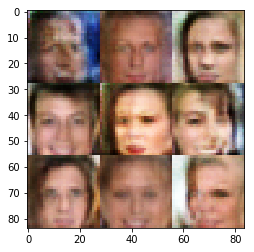


 Epoch 1/1, step 2450: 
 Discriminator loss: 1.4475 
 Generator loss: 0.8135 
 Total Time: 17.70 minutes

 Epoch 1/1, step 2500: 
 Discriminator loss: 1.4104 
 Generator loss: 0.7408 
 Total Time: 18.07 minutes


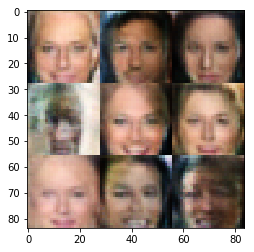


 Epoch 1/1, step 2550: 
 Discriminator loss: 1.4178 
 Generator loss: 0.7827 
 Total Time: 18.44 minutes

 Epoch 1/1, step 2600: 
 Discriminator loss: 1.3767 
 Generator loss: 0.7953 
 Total Time: 18.80 minutes


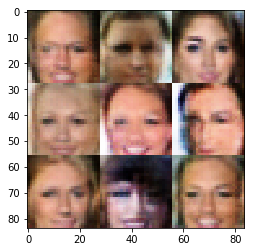


 Epoch 1/1, step 2650: 
 Discriminator loss: 1.4354 
 Generator loss: 0.7444 
 Total Time: 19.18 minutes

 Epoch 1/1, step 2700: 
 Discriminator loss: 1.4533 
 Generator loss: 0.8029 
 Total Time: 19.54 minutes


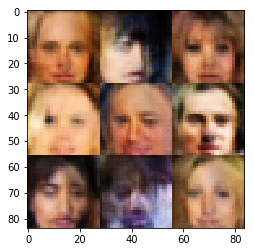


 Epoch 1/1, step 2750: 
 Discriminator loss: 1.4484 
 Generator loss: 0.7622 
 Total Time: 19.91 minutes

 Epoch 1/1, step 2800: 
 Discriminator loss: 1.4537 
 Generator loss: 0.7959 
 Total Time: 20.27 minutes


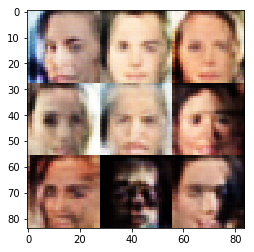


 Epoch 1/1, step 2850: 
 Discriminator loss: 1.3703 
 Generator loss: 0.7479 
 Total Time: 20.65 minutes

 Epoch 1/1, step 2900: 
 Discriminator loss: 1.4343 
 Generator loss: 0.7555 
 Total Time: 21.02 minutes


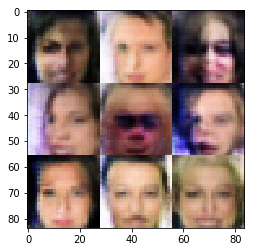


 Epoch 1/1, step 2950: 
 Discriminator loss: 1.4039 
 Generator loss: 0.7758 
 Total Time: 21.39 minutes

 Epoch 1/1, step 3000: 
 Discriminator loss: 1.4234 
 Generator loss: 0.7890 
 Total Time: 21.76 minutes


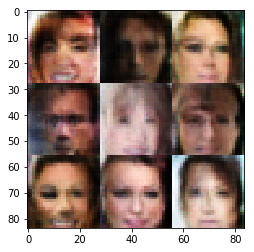


 Epoch 1/1, step 3050: 
 Discriminator loss: 1.4116 
 Generator loss: 0.7769 
 Total Time: 22.15 minutes

 Epoch 1/1, step 3100: 
 Discriminator loss: 1.4313 
 Generator loss: 0.7874 
 Total Time: 22.52 minutes


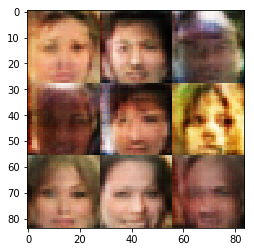


 Epoch 1/1, step 3150: 
 Discriminator loss: 1.4123 
 Generator loss: 0.7380 
 Total Time: 22.89 minutes


In [13]:
# Use same hyperparameters as for MNIST data.


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,alpha=alpha, smooth=smooth, 
          disc_dropOut=disc_dropOut, gen_dropOut=gen_dropOut)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.